Just for developing the CryoEnv2

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cait as ai
import cait.versatile as vai

# Get multiprocessing
n_processes = ai._available_workers
# Standard values for plotting
backend = "plotly" # Choose "mpl" for keeping plots when closing, "plotly" for interactive plotting

# Go up one level because notebook is in folder
import sys
import os
sys.path.append(os.path.abspath("."))  # Go to project root folder

# New cryoEnv implementation
from src.CryoEnv2 import CryoEnv as cryo

# Preparations
Before using our environment, all parts of it have to be defined. These are
1) Time + cryo environment
2) Electrothermal model
3) Heater
4) TES
5) SQUID

Thats always made in the same fashion, by defining a variable dictionary first, then init the part of the system (slightly differs for the first point).

Afterwards, the environment is fully defined and can be used!

## 1) Time and cryo environment definition
First of all, it is important to define the time vector for one testpulse event.
This should be kept similar to the events in cait, so we use the same record_length.

In [2]:
record_length = 2**14       # Standard value in cait
sample_frequency = 50e3     # Standard value in vdaq
dt = 1 / sample_frequency   # Time step

time = np.linspace(0, record_length/sample_frequency, record_length)  # Time vector
print("Maximum time is: ", np.max(time), "s")

Maximum time is:  0.32768 s


In [3]:
# Initialize cryo
test_env = cryo(record_length=record_length, sample_frequency=sample_frequency)

Cryogenic environment initialized.


## 2) Filling the ETM with life
First of all, the cryo environment has to be created.

In [4]:
# Create dict for all relevant electrothermal model parameters (2-comp model)
etm_params_2C = {
    "C_e": 22e-12,     # Heat capacity electrical system
    "C_a": 150e-12,     # Heat capacity absorber
    "G_ea": 140e-12,     # Thermal conductance between electrical system and absorber
    "G_ab": 5e-9,     # Thermal conductance between absorber and bath
    "G_eb": 7.5e-9,     # Thermal conductance between electrical system and bath
    "T_b": 15e-3,       # Bath temperature
    "R_S": 50e-3,      # Shunt resistance
    "L": 400e-9,      # Inductance from SQUID input coil
    "V_B": 5e-6,        # Bias voltage
}

# Initialize electrothermal model
test_env.init_etm(n_components=2, params=etm_params_2C) # give number of components, otherwise parameters will not fit

2-component Electrothermal model initialized.
TES initialized.


The parameter space differs a lot from the used system!

## 3) Define Heater
The DAC is the voltage value set to the Heater.
This is usually a constant DC, which is superimposed with Testpulses.
The constant part sets the OP of the detector.

Before using ´apply_testpulse´, the DC heater voltage (which defines the operating point) needs to be set.

In [5]:
# like for the etm parameter, also here can be a very short dictionary be defined
heater_params = {
    "R_H": 10e-3  # Typical resistance value: 10 mOh
}

# Before we can use the heater, we have to initialize it
test_env.init_heater(params=heater_params)

Heater initialized.


## 4) Define TES
The TES model is also strongly dependent on the parameters!

In [6]:
tes_params = {
    "R_T_max": 150e-3,  # Typical resistance value at normal conducting state: 10 mOhm
    "T_min": 10e-3,  # Beginn of transition: 0.05 K
    "T_c": 35e-3,     # Typical critical temperature: 0.1 K
    "T_max": 60e-3   # End of transition: 0.15 K
}

test_env.init_tes(model="sigmoid", params=tes_params)


TES initialized.


## 5) SQUID
Tbd
But: The TES current I_T is proportional to the SQUID output voltage U_s. So this is a problem from another day

# Start having fun!
I implemented a few methods, which can be extended.
First one I want to show, are the sweeps. Here we have mainly the following two:
- Heater sweep: Sweeping the Heater throughout the whole transition, no TP
- Bias sweep: ...

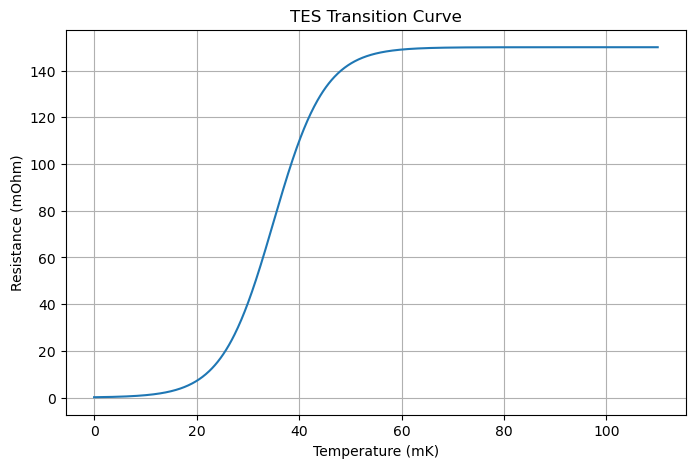

In [7]:
# Lets see a transition curve
test_env.plot_tes_transition()

In [8]:
# Get the response for a heater value
I_T = test_env.get_heater_response(V_H=50e-9)[0]  # Only get I_T, not T_e and T_a

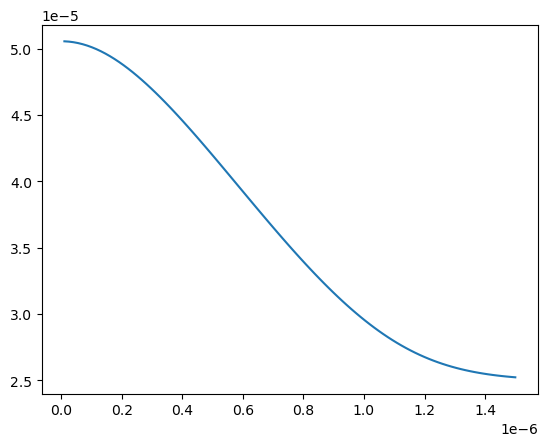

In [21]:
# This can be already used to do a Heater sweep
V_H = np.linspace(10e-9, 1500e-9, 100)  # Heater voltage values
I_B, T_e, T_a = test_env.get_heater_response(V_H)

plt.plot(V_H, I_B)